The goal of this project was to recognize and classify images of the 35 Gurmukhi characters with a CNN. The majority of the characters being worked with were handwritten. 

# The images of the characters came from 3 different distributions.   
a. Images of Gurmukhi characters from the Omniglot dataset (~20 samples of each character)

b. Image crops from various Gurmukhi Fonts, done manually (~40 samples of each character)

c. Gurmukhi Benchmark Dataset (~260 samples per character)   
Munish Kumar, M. K. Jindal, R. K. Sharma, S. R. Jindal, H. Singh, "Benchmark Datasets for Offline Handwritten Gurmukhi Script Recognition", Proceedings of the 4th Workshop on Document Analysis and Recognition, 2018. 

Some data cleaning was necessary. All images were converted to 100 x 100 png images with a bit depth of 1. For (c), the Gurmukhi Benchmark Dataset, the given data only had lines with a line width of a single pixel. To better standardize the data across the distributions, the line widths for each image in (c) were randomly thickened for between 3-6 pixels.

In total, there were 11870 samples of images, roughly evenly divided between the 35 characters. To form the training set, cross validation set, and testing set, characters were randomly taken from the above 3 distributions and divided for the proportions 80%, 10%, 10% respectively.

In [1]:
!unzip Gurmukhi_split.zip

Streaming output truncated to the last 5000 lines.
  inflating: Gurmukhi_split/Training/17 thuthaa/17 (56)_BR.png  
 extracting: Gurmukhi_split/Training/17 thuthaa/17 (6)_BR.png  
  inflating: Gurmukhi_split/Training/17 thuthaa/17 (65)_BR.png  
  inflating: Gurmukhi_split/Training/17 thuthaa/17 (68)_BR.png  
  inflating: Gurmukhi_split/Training/17 thuthaa/17 (7)_BR.png  
 extracting: Gurmukhi_split/Training/17 thuthaa/17 (8)_BR.png  
  inflating: Gurmukhi_split/Training/17 thuthaa/17 (9)_BR.png  
 extracting: Gurmukhi_split/Training/17 thuthaa/thaththa (1)1.2_Training.png  
 extracting: Gurmukhi_split/Training/17 thuthaa/thaththa (1)2.2_Testing.png  
 extracting: Gurmukhi_split/Training/17 thuthaa/thaththa (1)3.1_Testing.png  
 extracting: Gurmukhi_split/Training/17 thuthaa/thaththa (1)3.1_Training.png  
 extracting: Gurmukhi_split/Training/17 thuthaa/thaththa (10)1.2_Testing.png  
 extracting: Gurmukhi_split/Training/17 thuthaa/thaththa (10)2.1_Testing.png  
 extracting: Gurmukhi_spli

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
path = '/content/Gurmukhi_split/'

Taking inspiration from    
Budhouliya, Rishabh & Sharma, Rajendra & Singh, Harjeet. (2020). Recognition of Online Handwritten Gurmukhi Strokes using Convolutional Neural Networks. 578-586. 10.5220/0008960005780586   
Image augmentation seemed to help tremendously.

In [4]:
val_test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

training_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                            rotation_range=15,
                                                            zoom_range=[1,1.2],
                                                            width_shift_range=0.1,
                                                            height_shift_range=0.1,
                                                            fill_mode="constant",
                                                            val = 255)


training_data = training_gen.flow_from_directory(directory = (path + 'Training/'), target_size = (100,100), batch_size = 128, class_mode = 'categorical', color_mode="grayscale")
validation_data = val_test_gen.flow_from_directory(directory = (path + 'Cross Validation/'), target_size = (100,100), batch_size = 128, class_mode = 'categorical', color_mode="grayscale")
testing_data = val_test_gen.flow_from_directory(directory = (path + 'Testing/'), target_size = (100,100), batch_size = 128, class_mode = 'categorical', color_mode="grayscale")

Found 9530 images belonging to 35 classes.
Found 1170 images belonging to 35 classes.
Found 1170 images belonging to 35 classes.


In [5]:
labels = list(training_data.class_indices)

In [6]:
labels

['01 Ooraa',
 '02 Aeraa',
 '03 Eeree',
 '04 Sasaa',
 '05 Hahaa',
 '06 Kakaa',
 '07 Khakaa',
 '08 Gagaa',
 '09 Ghagaa',
 '10 Ngnaa',
 '11 Chachaa',
 '12 Chhachaa',
 '13 Jajaa',
 '14 Jhajhaa',
 '15 Njnaa',
 '16 tainkaa',
 '17 thuthaa',
 '18 dadhaa',
 '19 dhadhaa',
 '20 nhanhaa',
 '21 tataa',
 '22 thathaa',
 '23 dadaa',
 '24 dhudhaa',
 '25 nanaa',
 '26 papaa',
 '27 phaphaa',
 '28 babaa',
 '29 bhabhaa',
 '30 mamaa',
 '31 yayaa',
 '32 raraa',
 '33 lalaa',
 '34 vavaa',
 '35 rharha']

The Gurmukhi alphabet.

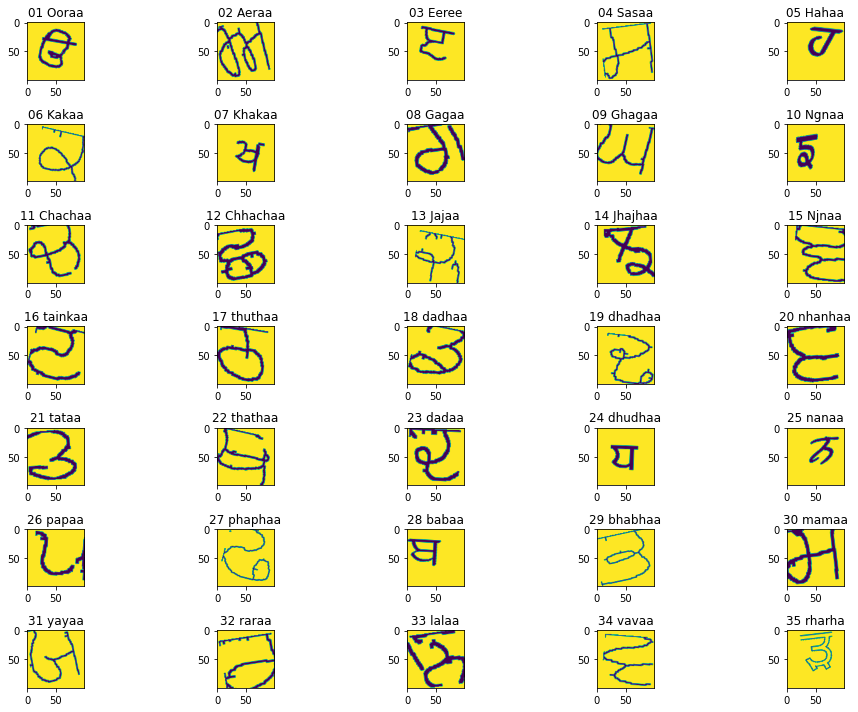

In [7]:
plt.figure(figsize=(14,10))
i = 0
while i < 35:
    x,y = training_data.next()
    for j in range(len(x)):
        if y[j][i] == 1:
            img = x[j].reshape(100,100)
            plt.subplot(7, 5, i + 1)
            plt.tight_layout()
            plt.title(labels[i])
            plt.imshow(img)
            i+=1
            if i == 35:
                break

Budhouliya, Sharma, and Singh (2020) tested 3 different CNN architectures and found that their 2nd model, ConvNet_Two, seemed to work the best. There were some notable differences, comparing this project to that project, such as the fact that they were using 60x60 images, they had 79 different classes, and they had less data to work with. However, ConvNet_Two had 2 convolutional layers stacked together 3 times with dropout regularization after each stack. I started testing with something similar to ConvNet_Two and experimented until arriving at the model below.

In [8]:
model = keras.models.Sequential()
model.add(layers.Conv2D(16, (5, 5), activation='relu', padding='same', input_shape=(100, 100, 1)))
model.add(layers.Conv2D(16, (5, 5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (5, 5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(35, activation ='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 16)      6416      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        12832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 64)        5

In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.fit(training_data,
                    validation_data=validation_data, epochs=250)

Epoch 1/250
75/75 [==============================] - 10s 138ms/step - loss: 3.5381 - accuracy: 0.0382 - val_loss: 3.4043 - val_accuracy: 0.1171
Epoch 2/250
75/75 [==============================] - 10s 132ms/step - loss: 3.0645 - accuracy: 0.1399 - val_loss: 1.9630 - val_accuracy: 0.4906
Epoch 3/250
75/75 [==============================] - 10s 133ms/step - loss: 2.2842 - accuracy: 0.3176 - val_loss: 1.0974 - val_accuracy: 0.6410
Epoch 4/250
75/75 [==============================] - 10s 134ms/step - loss: 1.8057 - accuracy: 0.4460 - val_loss: 0.8012 - val_accuracy: 0.7590
Epoch 5/250
75/75 [==============================] - 10s 134ms/step - loss: 1.4673 - accuracy: 0.5422 - val_loss: 0.5410 - val_accuracy: 0.8342
Epoch 6/250
75/75 [==============================] - 10s 135ms/step - loss: 1.2117 - accuracy: 0.6264 - val_loss: 0.3884 - val_accuracy: 0.8752
Epoch 7/250
75/75 [==============================] - 10s 134ms/step - loss: 1.0353 - accuracy: 0.6829 - val_loss: 0.2839 - val_accuracy:

The model seems to work very well, classifying characters correctly above 99% of the time.

In [12]:
model.evaluate(testing_data)

10/10 [==============================] - 0s 27ms/step - loss: 0.0491 - accuracy: 0.9915


[0.04912105202674866, 0.9914529919624329]

The model was able to classify each character correctly shown below

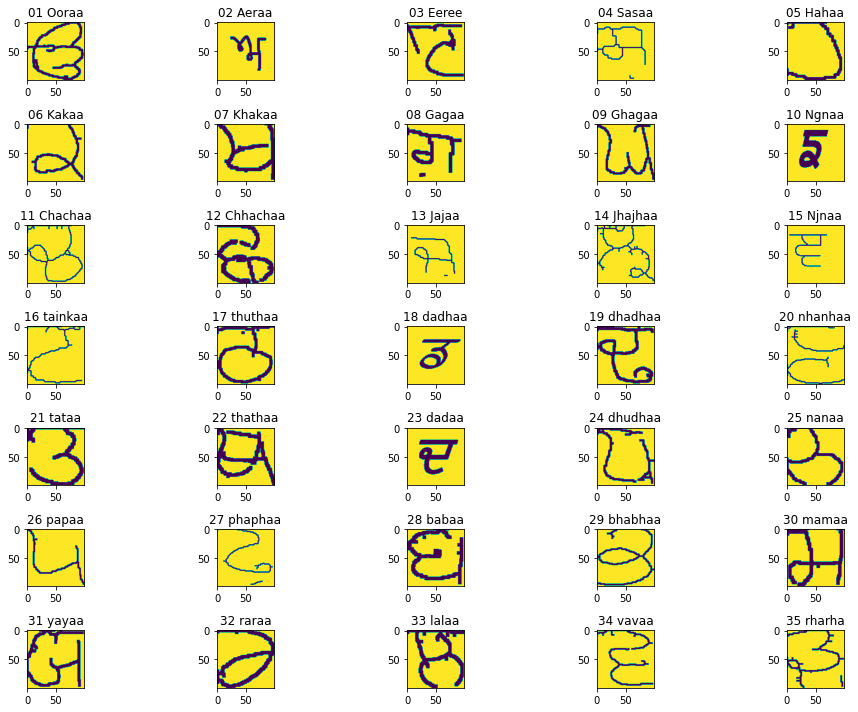

In [15]:
plt.figure(figsize=(14,10))

i = 0
while i < 35:
    x,y = testing_data.next()
    for j in range(len(x)):
        if y[j][i] == 1:
            img = x[j].reshape(100,100)
            plt.subplot(7, 5, i + 1)
            plt.tight_layout()
            plt.imshow(img)
            prediction = model.predict(np.array([x[j],])).argmax(axis=-1)
            plt.title(labels[prediction[0]])
            i+=1
            if i == 35:
                break